In [7]:
# 디렉토리 접근 용도
import os

# 이미지 로드 시 옵션 설정 용도
# pip3 install pillow
from PIL import ImageFile

# pip3 uninstall keras
# pip3 uninstall tensorflow
# pip3 install tensorflow --user
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# pip3 install numpy
import numpy as np

# pip3 install matplotlib
import matplotlib.pyplot as plt

# from 파일명 import 함수명
from get_tensor_through_imgs_fn import get_tensor_through_imgs_fn

from sklearn.model_selection import train_test_split
from datetime import datetime
from tqdm import tqdm
import cv2

In [8]:
# ========== 특정 파일 1개 불러와서 표시하기 ==========

# img_path = 'open/test/000.png'
# plt.imshow(imread(img_path))
# plt.show()

# ===================================================

In [9]:
# ======== 학습 시킬 모든 이미지 파일들의 경로에 대한 리스트와 라벨 데이터 리스트 생성하기 ========

# c:\Users\UserK\Desktop\hansol_J\jiwon_work\..\..\open\train
TRAIN_FOLDER_PATH = os.path.join(os.getcwd(), os.pardir, os.pardir, 'open', 'train')
# print('TRAIN_FOLDER_PATH : ', TRAIN_FOLDER_PATH)

def get_train_image_paths_and_labels_fn():

    defect_types = os.listdir(TRAIN_FOLDER_PATH)
    # print('defect_types :', defect_types)

    labels = []
    train_image_paths = []

    for defect_type in defect_types:

        file_names = os.listdir(os.path.join(TRAIN_FOLDER_PATH, defect_type))
        # print('file_names: ', file_names)

        for file_name in file_names:
            train_image_paths.append(os.path.join(TRAIN_FOLDER_PATH, defect_type, file_name))
            labels.append(defect_type)

    return train_image_paths, labels

train_image_paths, labels = get_train_image_paths_and_labels_fn()

# [ 하자 유형에 대한 폴더명\\파일명.확장자, ... ]
# print('train_image_paths: ', train_image_paths)

# [ 하자 유형에 대한 폴더명, ... ]
# print('labels :', labels)

# ==================================================================

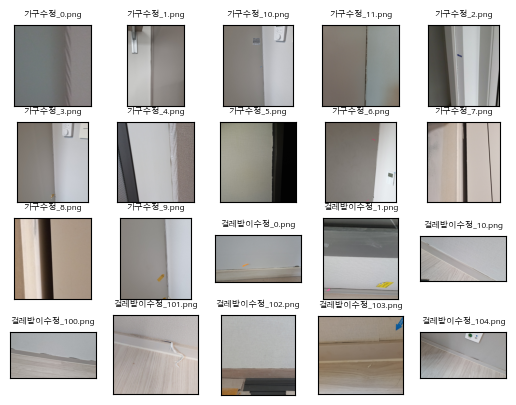

In [10]:
# ========= 학습용 이미지 리스트에서 20개만 확인해보기 =========

fig = plt.figure()

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

for index in range(20):
    ax = fig.add_subplot(4, 5, index + 1, xticks=[], yticks=[])

    img_path = train_image_paths[index]
    img_name = [*os.path.split(img_path)].pop()
    defect_type = labels[index]

    # 하자 유형_이미지 파일명.확장자
    title = f'{defect_type}_{img_name}'
    # print('title :', title)

    ax.set_title(title, fontsize=6)

    # issue: None
    # cause: 경로에 한글이 포함될 경우 발생함
    # img = cv2.imread(img_path)

    # solved
    img_array = np.fromfile(img_path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)

    # error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
    # solved: img 유무 확인하기
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# ============================================================


  0%|          | 0/3457 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 1/3457 [00:00<14:51,  3.88it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 3457/3457 [01:14<00:00, 46.20it/s]


train_image_tensor.shape : (3457, 100, 100, 3)


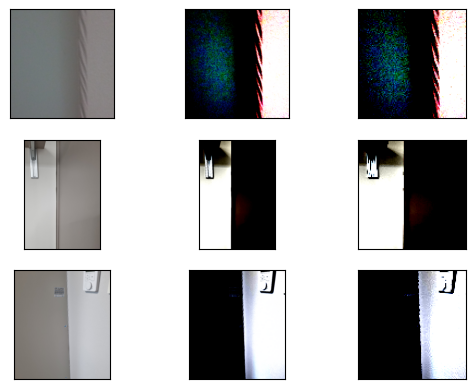

In [11]:
# ========= 교수님 코드 따라서 이미지 데이터를 가져오고 차원 변형하기 =========

# 잘린 이미지에 대한 로드 여부 설정
ImageFile.LOAD_TRUNCATED_IMAGES = True

RESIZED_WIDTH = 100
RESIZED_HEIGHT = 100

fig = plt.figure()

train_image_tensor = get_tensor_through_imgs_fn(train_image_paths, RESIZED_HEIGHT, RESIZED_WIDTH, fig)
print('train_image_tensor.shape :', train_image_tensor.shape)

# ==========================================================================


In [12]:
# ======== 교수님 코드 따라서 학습시키기 ========

EPOCHS = 40

# 학습 시킬 이미지 데이터에 대하여 정규화 (0 ~ 1)
normalized_train_image_tensor = train_image_tensor / 255
print('normalized_train_image_tensor.shape :',
      normalized_train_image_tensor.shape)

# 문자열 형태의 범주형 데이터인 라벨 데이터를 정수 형태로 정규화
normalized_labels = []

# 추후에 라벨이 추가될 경우 등 확장성 및 모델의 안정성을 고려하여 총 19가지의 하자 유형의 순서가 변경되지 않도록 직접적으로 리스트 생성
DEFECT_TYPE_NAMES = ["가구수정", "걸레받이수정", "곰팡이", "꼬임", "녹오염", "들뜸", "면불량", "몰딩수정", "반점", "석고수정",
                     "오염", "오타공", "울음", "이음부불량", "창틀,문틀수정", "터짐", "틈새과다", "피스", "훼손"]

defect_type_count = len(DEFECT_TYPE_NAMES)

for label in labels:
    normalized_labels.append(DEFECT_TYPE_NAMES.index(label))

# [ 0, 0, 0, ... ]
# print('normalized_labels :', normalized_labels)

# 정수형 클래스의 레이블을 이진 클래스의 원핫 인코딩 벡터로 변환
encoding_labels = to_categorical(normalized_labels, defect_type_count)
print('encoding_labels.shape :', encoding_labels.shape)

# 9:1 비율로 학습 시 사용할 데이터와 추론 시 사용할 데이터로 분리하고 랜덤성 부여
# x_for_train, x_test, y_for_train, y_test = train_test_split(
#     normalized_image_tensor, encoding_labels, test_size=0.1)

# 9:1 비율로 학습용 데이터와 검증용 데이터로 분리
# train_data_count = int(len(x_for_train) * 0.9)
# x_valid, y_valid = x_for_train[train_data_count:], y_for_train[train_data_count:]
# x_train, y_train = x_for_train[:train_data_count], y_for_train[:train_data_count]

# train 폴더 내의 모든 이미지 데이터에 대하여 학습 진행 (1개는 학습 중에 검증용 데이터로 사용)
x_train, x_valid, y_train, y_valid = train_test_split(
    normalized_train_image_tensor, encoding_labels, test_size=1)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(RESIZED_WIDTH, RESIZED_HEIGHT, 3)),
    tf.keras.layers.Conv2D(24, (5, 5), strides=(
        2, 2), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (5, 5), strides=(
        2, 2), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (5, 5), strides=(
        2, 2), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(19, activation='softmax'),
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

print('x_train.shape :', x_train.shape)
print('y_train.shape :', y_train.shape)

history = model.fit(x_train, y_train, epochs=EPOCHS,
                    validation_data=(x_valid, y_valid))

# 연월일_시간
now = datetime.today().strftime('%Y%m%d_%H%M%S')
model.save(f'model_{now}.h5')

# =============================================


normalized_train_image_tensor.shape : (3457, 100, 100, 3)
encoding_labels.shape : (3457, 19)
x_train.shape : (3456, 100, 100, 3)
y_train.shape : (3456, 19)
Epoch 1/40
108/108 [==============================] - 17s 147ms/step - loss: 2.2390 - acc: 0.3886 - val_loss: 0.8967 - val_acc: 1.0000
Epoch 2/40
108/108 [==============================] - 17s 156ms/step - loss: 2.1306 - acc: 0.3944 - val_loss: 0.8175 - val_acc: 1.0000
Epoch 3/40
108/108 [==============================] - 17s 155ms/step - loss: 2.0715 - acc: 0.4039 - val_loss: 0.5673 - val_acc: 1.0000
Epoch 4/40
108/108 [==============================] - 16s 144ms/step - loss: 1.9833 - acc: 0.4045 - val_loss: 0.4960 - val_acc: 1.0000
Epoch 5/40
108/108 [==============================] - 16s 145ms/step - loss: 1.9298 - acc: 0.4080 - val_loss: 0.5874 - val_acc: 1.0000
Epoch 6/40
108/108 [==============================] - 16s 150ms/step - loss: 1.8640 - acc: 0.4277 - val_loss: 0.3862 - val_acc: 1.0000
Epoch 7/40
108/108 [==============

loss : [2.238980531692505, 2.1305630207061768, 2.0714826583862305, 1.9833372831344604, 1.9298372268676758, 1.864018201828003, 1.7809010744094849, 1.7248846292495728, 1.6837855577468872, 1.618288516998291, 1.5407439470291138, 1.4635964632034302, 1.421485185623169, 1.3472001552581787, 1.2964228391647339, 1.221306562423706, 1.1694163084030151, 1.1002367734909058, 1.0304474830627441, 0.9426849484443665, 0.9348027110099792, 0.8407734036445618, 0.7967810034751892, 0.7440879344940186, 0.7452800869941711, 0.6629810929298401, 0.6289896368980408, 0.5910149216651917, 0.5895772576332092, 0.5649878978729248, 0.5120733976364136, 0.45723220705986023, 0.48204103112220764, 0.4426233768463135, 0.45882999897003174, 0.43424347043037415, 0.4003267288208008, 0.3797737658023834, 0.3607555329799652, 0.35837626457214355]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


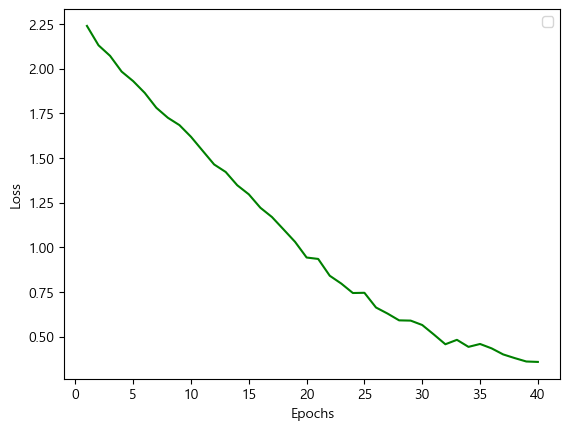

In [13]:
# ======= 학습 횟수에 따른 오차 변화 그래프 =======

loss = history.history['loss']
print('loss :', loss)

plt.plot(range(1, EPOCHS + 1), loss, 'g')
plt.title = 'Tranning Loss'
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# ===============================================